An autoencoder Consists of:  

    1. Encoder
    2. Decoder
    
Encoder/Decoder are fully connected feed foward neural networks
and the bottleneck is 
    

In [2]:
import torch
from torch import nn
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import time
import random
import torchvision.utils as vutils
from  torch.utils import data
from mpl_toolkits.axes_grid1 import ImageGrid


NUM_EPOCHS = 150
LR = 1e-3
LATENT_DIM = 100
IMG_SIZE = 28
CHANNELS = 1
B1 = 0.5
B2 = 0.999


GEN_STATE_DICT = "gen_state_dict"
DISC_STATE_DICT = "disc_state_dict"
GEN_OPTIMIZER = "gen_optimizer"
DISC_OPTIMIZER = "disc_optimizer"
G_LOSSES = "g_losses"
D_LOSSES = "d_losses"



SHUFFLE = True
PIN_MEMORY = True
NUM_WORKERS = 0
BATCH_SIZE = 750

specific_latent = torch.tensor([[0.7628, 0.1779, 0.3978, 0.3606, 0.6387,
         0.3044, 0.8340, 0.3884, 0.9313, 0.5635, 0.1994, 0.6934, 0.5326,
         0.3676, 0.5342, 0.9480, 0.4120, 0.5845, 0.4035, 0.5298, 0.0177,
         0.5605, 0.6453, 0.9576, 0.7153, 0.1923, 0.8122, 0.0937, 0.5744,
         0.5951, 0.8890, 0.4838, 0.5707, 0.6760, 0.3738, 0.2796, 0.1549,
         0.8220, 0.2800, 0.4051, 0.2553, 0.1831, 0.0046, 0.9021, 0.0264,
         0.2327, 0.8261, 0.0534, 0.1582, 0.4087, 0.9047, 0.1409, 0.6864,
         0.1439, 0.3432, 0.1072, 0.5907, 0.6756, 0.6942, 0.6814, 0.3368,
         0.4138, 0.8030, 0.7024, 0.3309, 0.7288, 0.2193, 0.1954, 0.9948,
         0.1201, 0.9483, 0.7407, 0.4849, 0.6500, 0.8649, 0.7405, 0.4725,
         0.5373, 0.6541, 0.5444, 0.7425, 0.8940, 0.3580, 0.3905, 0.8924,
         0.2995, 0.3726, 0.5399, 0.3057, 0.3380, 0.8313, 0.1137, 0.0120,
         0.7714, 0.2561, 0.2569, 0.2994, 0.7648, 0.2413, 0.6101
        ]])


img_shape = (CHANNELS, IMG_SIZE, IMG_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:{}'.format(device))

Device:cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
    ])


train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = data.DataLoader(
                                train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=SHUFFLE,
                                num_workers=NUM_WORKERS,
                                pin_memory=PIN_MEMORY
                                )

test_loader = data.DataLoader(
                                test_dataset,
                                batch_size=32,
                                shuffle=True,
                                num_workers=0
                                )

example_loader = data.DataLoader(
                                train_dataset,
                                batch_size=1,
                                shuffle=True,
                                num_workers=0,
                                drop_last=True,
                                )

In [4]:
#Helper functions
def plot():
    f, axarr = plt.subplots(2)

    for i, item in enumerate(image):
    # Reshape the array for plotting
        item = item.reshape(-1, 28, 28)
        axarr[0].imshow(item[0].cpu())

    for i, item in enumerate(reconstructed):
        item = item.reshape(-1, 28, 28).cpu()
        item = item.detach().numpy()
        axarr[1].imshow(item[0])
        
        
        
def showExample():
    for image, _ in example_loader:
        f, axarr = plt.subplots(2)
        image = image.reshape(-1,28*28).to(device)

        model.to(device)
        recon = model(image)

        image = image.reshape(-1, 28, 28)
        axarr[0].imshow(image[0].cpu())


        recon = recon.reshape(-1, 28, 28).to('cpu')
        axarr[1].imshow(recon[0].detach().numpy())

        break

def add_noise(inputs,variance):
    noise = torch.randn_like(inputs)
    return inputs + variance*noise


def save_checkpoint(state, filename):
    print("=> Saving chekpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint):
    generator.load_state_dict(checkpoint[GEN_STATE_DICT])
    optimizer_G.load_state_dict(checkpoint[GEN_OPTIMIZER])
    discriminator.load_state_dict(checkpoint[DISC_STATE_DICT])
    optimizer_D.load_state_dict(checkpoint[DISC_OPTIMIZER])
    if 'G_losses' in locals() and 'D_losses' in locals():
        G_losses.load_state_dict(checkpoint[G_LOSSES])
        D_losses.load_state_dict(checkpoint[D_LOSSES])
        
        
        

First we will be constructing the encoder and decoder, 2 fully connected, feed forward Neural networks  

Encoder will gradually reduce dimentionality  
28*28=784 -> 128 -> 64 -> 36 -> 18 -> 9
  
Decoder will do the opposite


In [5]:
input_size = 28*28  #784
hidden_size = 128
code_size = 32


class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Encoder 
        self.encoder = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,code_size)
        )
        
        #Decoder
        self.decoder = nn.Sequential(
            nn.Linear(code_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )
        self.model = nn.Sequential(
        
        )
        
        
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
        
        

In [6]:

# Model Initialization
model = autoencoder()

 
# Validation using MSE Loss function
loss_function = nn.MSELoss()

#Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(B1 ,B2))

if torch.cuda.is_available():
    model.cuda()
    loss_function.cuda()


### Train model for 20 epoch:
Things to notice:
- Firstly we are setting to zero gradient before each backpropagation
    because pytorch accumulates the gradients on subsequent backward losses
    (this may be usefull when training RNNs)
- then we are passing the image through the model and calculate loss with a simple MSE Loss$$ (x - g(f(x)))^{2} $$

- loss.backward() computes loss and we are preforming backpropagation with optimizer.step()


In [9]:
epochs = 20
losses = []

if torch.cuda.is_available():
    model.to(device)
    loss_function.to(device)


for epoch in range(epochs):
    for image, _ in train_loader:
        image = image.reshape(-1,28*28).to(device)
        noised_image = add_noise(image,0.2)
        #set gradients to zero
        
        reconstructed = model(noised_image)
        loss = loss_function(reconstructed , noised_image)
        
        optimizer.zero_grad()
        loss.backward() # Preforms Backpropagation and calculates  gradients 
        optimizer.step() # Updates Weights based on the gradients computed above
        losses.append(loss.item())
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss.item()))

        

epoch : 1/20, loss = 0.965003
epoch : 2/20, loss = 0.959192
epoch : 3/20, loss = 0.951827
epoch : 4/20, loss = 0.941436
epoch : 5/20, loss = 0.934414
epoch : 6/20, loss = 0.927131
epoch : 7/20, loss = 0.916178
epoch : 8/20, loss = 0.914586
epoch : 9/20, loss = 0.913440
epoch : 10/20, loss = 0.911182
epoch : 11/20, loss = 0.906704
epoch : 12/20, loss = 0.905187
epoch : 13/20, loss = 0.903915
epoch : 14/20, loss = 0.905286
epoch : 15/20, loss = 0.903373
epoch : 16/20, loss = 0.901832
epoch : 17/20, loss = 0.905089
epoch : 18/20, loss = 0.904244
epoch : 19/20, loss = 0.900170
epoch : 20/20, loss = 0.901494


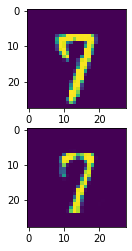

In [11]:
showExample()

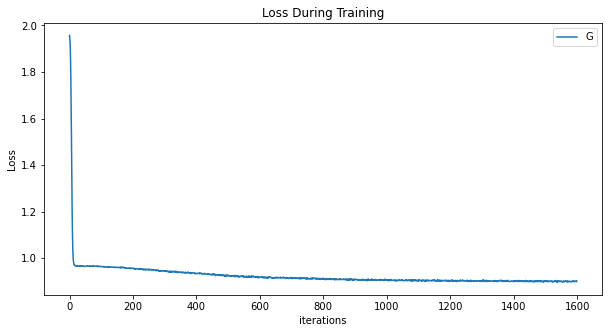

In [12]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(losses,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
for image, _ in train_loader:
    #example = torch.movedim(image[0],(1,2),(0,1))
   
    f, axarr = plt.subplots(2)
    image = image.reshape(-1,28*28).to(device)
    
    image = add_noise(image,0.0)
    model.to(device)
    recon = model(image)
    image = image.reshape(-1, 28, 28)
   
    axarr[0].imshow(image[0].cpu())
    

    
    recon = recon.reshape(-1, 28, 28).to('cpu')
    #example = torch.movedim(example,(0,1,2),(-1,-2,-3))
    axarr[1].imshow(recon[0].detach().numpy())

    break    
    
    
    